In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# warnings.filterwarnings('ignore')

import globalsettings as gs

In [4]:
print("DIR ROOT = {}", gs.prj_files.dir_root)

DIR ROOT = {} c:\users\mcondedesimon\onedrive - deloitte (o365d)\documents\playground\cltv


In [7]:
data_clv_raw = pd.read_excel(gs.FILE_RETAIL_DATA)

In [8]:
data_clv_raw

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [33]:
features = ['CustomerID', 'InvoiceNo', 'InvoiceDate', 'Quantity', 'UnitPrice']
data_clv = data_clv[features]
data_clv["TotalSales"] =  data_clv["Quantity"].multiply(data_clv["UnitPrice"])
data_clv = data_clv[data_clv['TotalSales'] > 0]
data_clv

,CustomerID,InvoiceNo,InvoiceDate,Quantity,UnitPrice,TotalSales
0,17850.0,536365,2010-12-01 08:26:00,6,2.55,15.30
1,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
2,17850.0,536365,2010-12-01 08:26:00,8,2.75,22.00
3,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
4,17850.0,536365,2010-12-01 08:26:00,6,3.39,20.34
...,...,...,...,...,...,...
541904,12680.0,581587,2011-12-09 12:50:00,12,0.85,10.20
541905,12680.0,581587,2011-12-09 12:50:00,6,2.10,12.60
541906,12680.0,581587,2011-12-09 12:50:00,4,4.15,16.60
541907,12680.0,581587,2011-12-09 12:50:00,4,4.15,16.60


In [34]:
max_date = data_clv["InvoiceDate"].dt.date.max()
min_date = data_clv["InvoiceDate"].dt.date.min()
unique_cust = data_clv["CustomerID"].nunique()
tot_quantity = data_clv["Quantity"].sum()
tot_sales = data_clv["TotalSales"].sum()

print(f"Dates range: {min_date} - {max_date}")
print(f"Unique customers: {unique_cust}")
print(f"Total Quantity: {tot_quantity}")
print(f"Total Sales: {tot_sales}")

Dates range: 2010-12-01 - 2011-12-09
Unique customers: 4338
Total Quantity: 5588376
Total Sales: 10666684.544


In [28]:
data_clv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 6 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   CustomerID   406829 non-null  float64       
 1   InvoiceNo    541909 non-null  object        
 2   InvoiceDate  541909 non-null  datetime64[ns]
 3   Quantity     541909 non-null  int64         
 4   UnitPrice    541909 non-null  float64       
 5   TotalSales   541909 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(1)
memory usage: 24.8+ MB


# Agregando todo

El CLV de un cliente en T periodos de tiempo es:

$$
\text{CLV} = \sum_{t=1}^{T} [\text{Sales}(t) \times \text{Margin}(t) \times \text{R}(t)]
$$

donde $\text{R}(t)$ es la probabilidad de permanecer como cliente en el periodo $t$.

Hacemos las aproximaciones:

+ $\text{Sales}(t) [\frac{€}{u.de.t}] = \text{Purchase Frequency} [\frac{purchases}{u.de.t}] \times \text{AvgSales} [\frac{€}{purchase}]$
+ $\text{Margin}(t)  = \text{M}$

de manera que:

$$
\text{CLV} = \text{AvgSales} \times \text{Purchase Frequency}  \times \text{M} \times \sum_{t=1}^{T} \text{R}(t)
$$

En cuanto a $\text{R}(t)$, sea $\text{c}(t) = \text{c}$ la probabilidad de que el cliente abandone en el periodo $t$. Entonces:

$$
\text[R](t) = \prod_{i=1}^t[1 - c(i)] = [1 - c]^t
$$

$$
\text{CLV} = \frac{\text{Average Sales} \times \text{Purchase Frequency}}{\text{Churn Rate}} \times \text{Profit Margin}
$$

In [38]:
customer = data_clv.groupby("CustomerID").agg({'InvoiceDate': lambda x: (x.max() - x.min()).days,
                                               'InvoiceNo': lambda x: len(x),
                                               'TotalSales': lambda x: sum(x)})

customer.columns = ['Age', "Frequency", 'TotalSales']

customer

,Age,Frequency,TotalSales
CustomerID,,,
12346.0,0,1,77183.60
12347.0,365,182,4310.00
12348.0,282,31,1797.24
12349.0,0,73,1757.55
12350.0,0,17,334.40
...,...,...,...
18280.0,0,10,180.60
18281.0,0,7,80.82
18282.0,118,12,178.05


In [46]:
average_sales = np.mean(customer['TotalSales'])
purchase_freq = np.mean(customer['Frequency'])
retention_rate = customer[customer['Frequency'] > 1].shape[0] / customer.shape[0]
churn = 1- retention_rate

print(f"Average Sales: {round(average_sales, 2)}")
print(f"Average Frequency: {round(purchase_freq, 2)}")
print(f"Retention Rate: {round(retention_rate, 2)}")
print(f"Churn Rate: {round(churn, 2)}")

Average Sales: 2054.27
Average Frequency: 91.72
Retention Rate: 0.98
Churn Rate: 0.02


In [47]:
PROFIT_MARGIN = 0.05

clv = average_sales * purchase_freq / churn * PROFIT_MARGIN

print(f"CLV = {round(clv, 2)}")

CLV = 575605.46


## Por cohortes

Para mejorar el anterior podemos sacar un CLV por grupos de clientes, por ejemplo por cohortes determinadas por el mes de la primera compra del cliente

# Enfoque Predictivo

## Modelo Machine Learning

## Modelo Probabilístico

Se usa un modelo para predecir las transacciones (*purchase frequency*) y el *churn* **en el futuro**

+ Pareto / NBD (*Negative Binomial Distribution*)
+ BG (Beta Gamma) / NBD 
+ Otros

y otro modelo para predecir los valores monetarios futuros (*average order value*)

+ Gamma-Gamma Model

In [48]:
import lifetimes

In [58]:
# RFM Table (Recency, Frequency, Monetary Value)
summary = lifetimes.utils.summary_data_from_transaction_data(data_clv, customer_id_col= 'CustomerID', datetime_col='InvoiceDate', monetary_value_col= 'TotalSales')
summary.reset_index(inplace=True)
summary

,CustomerID,frequency,recency,T,monetary_value
0,12346.0,0.0,0.0,325.0,0.000000
1,12347.0,6.0,365.0,367.0,599.701667
2,12348.0,3.0,283.0,358.0,301.480000
3,12349.0,0.0,0.0,18.0,0.000000
4,12350.0,0.0,0.0,310.0,0.000000
...,...,...,...,...,...
4333,18280.0,0.0,0.0,277.0,0.000000
4334,18281.0,0.0,0.0,180.0,0.000000
4335,18282.0,1.0,119.0,126.0,77.840000
4336,18283.0,13.0,334.0,337.0,152.802308


+ **frequency** — the number of repeat purchases (more than 1 purchases)
+ **recency** — the time between the first and the last transaction
+ **T** — the time between the first purchase and the end of the transaction period (last date of the time frame considered for the analysis)
+ **monetary_value** — it is the mean of a given customers sales value

### *Churn* y Transacciones

In [59]:
# Fit BG / NBD Model
bg_nbd = lifetimes.BetaGeoFitter(penalizer_coef=0.0)
bg_nbd = bg_nbd.fit(summary['frequency'], summary['recency'], summary['T'])

In [61]:
bg_nbd.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.826542,0.026785,0.774044,0.879040
alpha,68.905121,2.611786,63.786020,74.024221
a,0.003437,0.010339,-0.016828,0.023702
b,6.745116,22.414725,-37.187745,50.677978


#### Probabilidad de que un cliente con historia (frequency, recency, T) esté vivo actualmente:

In [63]:
summary['probability_alive'] = bg_nbd.conditional_probability_alive(summary['frequency'], summary['recency'], summary['T'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive
0,12346.0,0.0,0.0,325.0,0.000000,1.000000
1,12347.0,6.0,365.0,367.0,599.701667,0.999698
2,12348.0,3.0,283.0,358.0,301.480000,0.999177
3,12349.0,0.0,0.0,18.0,0.000000,1.000000
4,12350.0,0.0,0.0,310.0,0.000000,1.000000
...,...,...,...,...,...,...
4333,18280.0,0.0,0.0,277.0,0.000000,1.000000
4334,18281.0,0.0,0.0,180.0,0.000000,1.000000
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797


<AxesSubplot: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

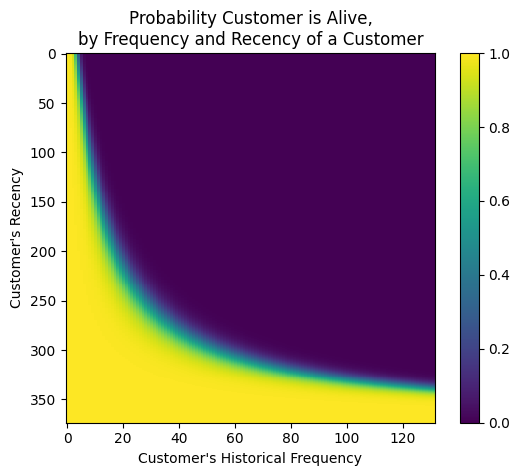

In [68]:
from lifetimes.plotting import plot_probability_alive_matrix

fig = plt.figure()
plot_probability_alive_matrix(bg_nbd)

#### Predicción de las transacciones futuras por cliente:

In [69]:
# VENTANA
t = 30
summary['pred_num_transactions'] = bg_nbd.conditional_expected_number_of_purchases_up_to_time(t, summary['frequency'], summary['recency'], summary['T'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions
0,12346.0,0.0,0.0,325.0,0.000000,1.000000,0.062948
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469643
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.268666
3,12349.0,0.0,0.0,18.0,0.000000,1.000000,0.285282
4,12350.0,0.0,0.0,310.0,0.000000,1.000000,0.065439
...,...,...,...,...,...,...,...
4333,18280.0,0.0,0.0,277.0,0.000000,1.000000,0.071682
4334,18281.0,0.0,0.0,180.0,0.000000,1.000000,0.099616
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455,0.280964
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797,1.021601


## Predicción del valor monetario

In [72]:
# Check
return_customers_summary = summary[summary['frequency'] > 0]
return_customers_summary[['frequency', 'monetary_value']].corr()

,frequency,monetary_value
frequency,1.000000,0.015906
monetary_value,0.015906,1.000000


In [74]:
# Fit the GG model
gg = lifetimes.GammaGammaFitter(penalizer_coef=0.01)
gg.fit(return_customers_summary['frequency'], return_customers_summary['monetary_value'])
gg.summary

,coef,se(coef),lower 95% bound,upper 95% bound
p,3.753678,0.096758,3.564032,3.943323
q,0.334753,0.007177,0.320687,0.348819
v,3.643551,0.098026,3.451419,3.835683


In [75]:
# Predict conditional Expected Average Profit for each customer per transactions
summary = summary[summary['monetary_value'] > 0]
summary['exp_avg_sales'] = gg.conditional_expected_average_profit(summary['frequency'], summary['monetary_value'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,exp_avg_sales
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469643,618.580281
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.268666,321.698923
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.560850,380.090885
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.215146,298.146326
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.250170,834.789440
...,...,...,...,...,...,...,...,...
4327,18272.0,5.0,244.0,246.0,487.752000,0.999668,0.554840,506.431204
4328,18273.0,2.0,255.0,257.0,76.500000,0.999549,0.260052,85.936874
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455,0.280964,99.035083
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797,1.021601,155.198357


In [77]:
# Check
print(f"Expected Average Sales: {summary['exp_avg_sales'].mean()}")
print(f"Actual Average Sales: {summary['monetary_value'].mean()}")

Expected Average Sales: 532.4338840620105
Actual Average Sales: 477.3803385139514


## Predicción del CLV

In [78]:
# CLV para el próximo mes
summary['pred_clv'] = gg.customer_lifetime_value(bg_nbd,
                                                 summary['frequency'],
                                                 summary['recency'],
                                                 summary['T'],
                                                 summary['monetary_value'],
                                                 time = 1, # lifetime in months,
                                                 freq = "D", # frequency in which the data is present (T)
                                                 discount_rate = 0.01
                                                 ) 

summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,exp_avg_sales,pred_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469643,618.580281,287.635525
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.268666,321.698923,85.573948
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.560850,380.090885,211.063388
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.215146,298.146326,63.509970
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.250170,834.789440,206.771574
...,...,...,...,...,...,...,...,...,...
4327,18272.0,5.0,244.0,246.0,487.752000,0.999668,0.554840,506.431204,278.206193
4328,18273.0,2.0,255.0,257.0,76.500000,0.999549,0.260052,85.936874,22.126768
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455,0.280964,99.035083,27.549758
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797,1.021601,155.198357,156.981022


In [79]:
# CLV a mano
summary['manual_pred_clv'] = summary['pred_num_transactions'].multiply(summary['exp_avg_sales'])
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,exp_avg_sales,pred_clv,manual_pred_clv
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469643,618.580281,287.635525,290.511881
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.268666,321.698923,85.573948,86.429687
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.560850,380.090885,211.063388,213.174022
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.215146,298.146326,63.509970,64.145069
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.250170,834.789440,206.771574,208.839290
...,...,...,...,...,...,...,...,...,...,...
4327,18272.0,5.0,244.0,246.0,487.752000,0.999668,0.554840,506.431204,278.206193,280.988255
4328,18273.0,2.0,255.0,257.0,76.500000,0.999549,0.260052,85.936874,22.126768,22.348036
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455,0.280964,99.035083,27.549758,27.825256
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797,1.021601,155.198357,156.981022,158.550833


### CLV como margen

Podíamos haber puesto margen desde el principio en lugar de ventas pero, como hemos usado ventas, tenemos que calcularlo ahora.

In [80]:
profit_margin = 0.05

summary['pred_clv_margin'] = summary['pred_clv'] * profit_margin
summary

,CustomerID,frequency,recency,T,monetary_value,probability_alive,pred_num_transactions,exp_avg_sales,pred_clv,manual_pred_clv,pred_clv_margin
1,12347.0,6.0,365.0,367.0,599.701667,0.999698,0.469643,618.580281,287.635525,290.511881,14.381776
2,12348.0,3.0,283.0,358.0,301.480000,0.999177,0.268666,321.698923,85.573948,86.429687,4.278697
5,12352.0,6.0,260.0,296.0,368.256667,0.999406,0.560850,380.090885,211.063388,213.174022,10.553169
9,12356.0,2.0,303.0,325.0,269.905000,0.999478,0.215146,298.146326,63.509970,64.145069,3.175498
11,12358.0,1.0,149.0,150.0,683.200000,0.999486,0.250170,834.789440,206.771574,208.839290,10.338579
...,...,...,...,...,...,...,...,...,...,...,...
4327,18272.0,5.0,244.0,246.0,487.752000,0.999668,0.554840,506.431204,278.206193,280.988255,13.910310
4328,18273.0,2.0,255.0,257.0,76.500000,0.999549,0.260052,85.936874,22.126768,22.348036,1.106338
4335,18282.0,1.0,119.0,126.0,77.840000,0.999455,0.280964,99.035083,27.549758,27.825256,1.377488
4336,18283.0,13.0,334.0,337.0,152.802308,0.999797,1.021601,155.198357,156.981022,158.550833,7.849051
